# Statistics

In this notebook, I want to see what kinds of predictions I can make using the text of the titles. One thing I will try to predict is the number of citations. Another thing I want to try is to predict the author based on the text of the title. And I will also try predicting the school based on the title.

In [1]:
import csv
import pandas as pd
import numpy as np
import random
import string

In [2]:
import nltk
from nltk.stem.porter import PorterStemmer

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.model_selection import LeaveOneOut

In [4]:
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)

In [5]:
# Read in the data line-by-line
datcsv = open('cleaned.txt','r')
dat = csv.reader(datcsv, delimiter = ' ',quotechar='"')
df = pd.DataFrame(next(dat))
df = df.transpose()

for i in dat:
    df_ = pd.DataFrame([i])
    df = pd.concat([df, df_])

datcsv.close()

In [6]:
df.columns = ['school', 'name', 'citedby', 'title', 'year']
df['year'] = pd.to_numeric(df['year'])
df['citedby'] = pd.to_numeric(df['citedby'])
df = df.reset_index(drop = True)

I want the response variable to be the number of citations, but papers that were published longer ago would probably tend to have more citations, so I think citations per year would be a better response variable.

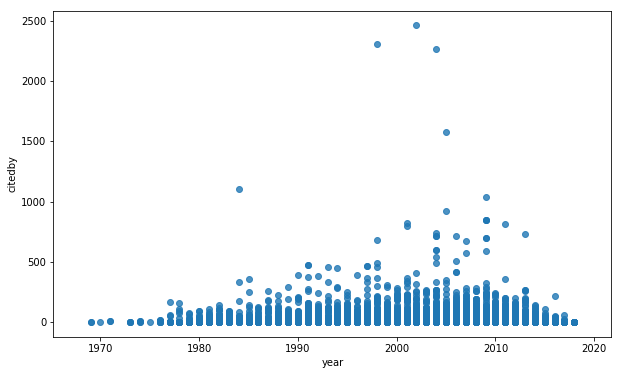

In [13]:
sns.regplot(df.year, df.citedby, fit_reg = False)

Contrary to my belief, earlier publications were not cited the most. Publications from 2000-2010 seem to be cited the most. This may be because older publications become outdated and are not cited as much after a certain number of years. Because of this, I will not use citations per year, and just stick with the total number of citations.

In [10]:
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """Extract simple lemmas based on tokenization and stemming"""
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem(tokens, stemmer)
    return stems

In [11]:
#vectorize the text i.e. convert the strings to numeric featres
vectorizer = TfidfVectorizer(tokenizer = lemmatize, stop_words = 'english', 
                             smooth_idf = True, norm = None)
X = vectorizer.fit_transform(df['title'])

In [12]:
# From Lecture 9 in class
def loo_risk(X,y,regmod):
    """
    Construct the leave-one-out square error risk for a regression model
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar LOO risk
    """
    loo = LeaveOneOut()
    loo_losses = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regmod.fit(X_train,y_train)
        y_hat = regmod.predict(X_test)
        loss = np.sum((y_hat - y_test)**2)
        loo_losses.append(loss)
    return np.mean(loo_losses)

def emp_risk(X,y,regmod):
    """
    Return the empirical risk for square error loss
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar empirical risk
    """
    regmod.fit(X,y)
    y_hat = regmod.predict(X)
    return np.mean((y_hat - y)**2)

In [13]:
y = np.array(df.citedby)

LOOs = []
MSEs = []

Ks = range(1,21,2)

for k in Ks:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    LOOs.append(loo_risk(X,y,knn))
    MSEs.append(emp_risk(X,y,knn))

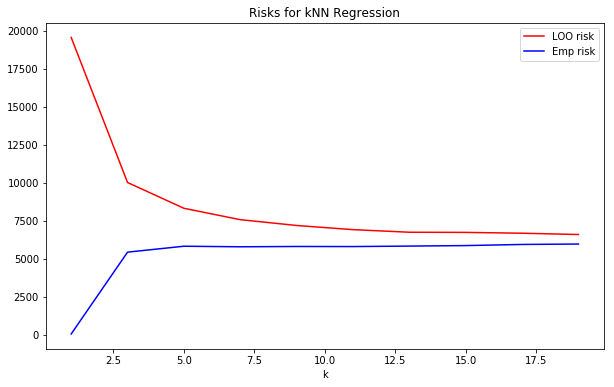

In [14]:
plt.plot(Ks,LOOs,'r',label="LOO risk")
plt.title("Risks for kNN Regression")
plt.plot(Ks,MSEs,'b',label="Emp risk")
plt.legend()
_ = plt.xlabel('k')

In [15]:
np.mean((df.citedby - df.citedby.mean())**2.)

6400.95193098332

This graph indicates that the higher the k, the better. Using a higher k value is basically just taking the average to predict for every title, and the LOO error rate converges to about 6400, which is the MSE we would get if we predicted the average every time, making this a very bad model.

It makes sense that the titles alone is not very effective for predicting the number of citations. For example, one confounding variable could be the journal, since some journals have higher impact factors than others.

Next, let's see how well we can use this dataset to predict the author based on the publication title.

In [72]:
k_max = 30
err_list = []

y = np.array(df.name)

for k in range(1,k_max+1,2):
    nbrs = KNeighborsClassifier(n_neighbors=k).fit(X, y) 
    pred_lab = nbrs.predict(X)
    err =  np.mean(pred_lab != y)
    err_list.append(err)

Text(0,0.5,'Emprical Error Rate')

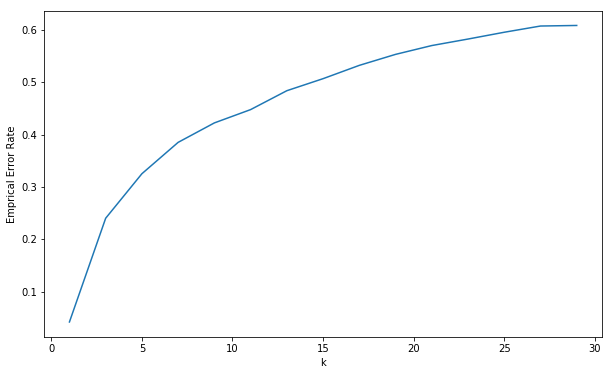

In [73]:
plt.plot(range(1,k_max + 1,2),err_list)
plt.xlabel('k')
plt.ylabel('Emprical Error Rate')

This graph of empirical error rate tells the same story as above. At k=1, where the observation is its own nearest neighbor, the error rate is of course 0. However, as we increase k, the prediction keeps getting worse. One issue with this model may be that there are too many choices for the response variable. It may be very hard to choose among 56 professors.

Since choosing among 56 professors may be too many choices, another thing to try is to predict the school based on the publication title.

In [74]:
k_max = 30
err_list = []
y = np.array(df.school)

for k in range(1,k_max+1,2):
    nbrs = KNeighborsClassifier(n_neighbors=k).fit(X, y) 
    pred_lab = nbrs.predict(X)
    err =  np.mean(pred_lab != y)
    err_list.append(err)

Text(0,0.5,'Emprical Error Rate')

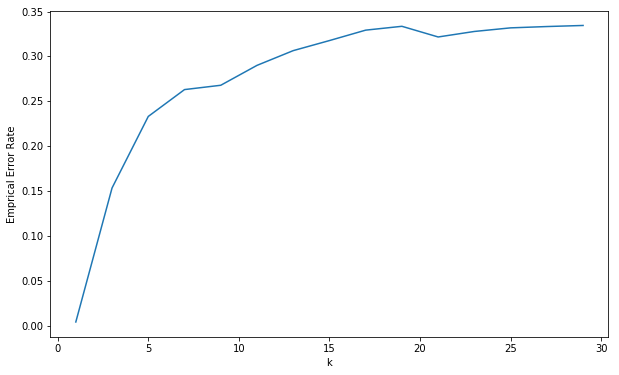

In [75]:
plt.plot(range(1,k_max + 1,2),err_list)
plt.xlabel('k')
plt.ylabel('Emprical Error Rate')

This graph of empirical error rate tells another similar story. The error rate keeps increasing with k. The issue with this may be that the schools are not different enough from each other.

# Why are the predictions so bad?   
Since it seems that the clustering of the text has nothing to with citations, author, or school, let's see how to text clusters on its own. For this, let's use kmeans.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.sparse import csr_matrix

When I used random initializations, I found that the clustering was very unstable, and would commonly have very unbalanced clusters, even when I chose a low k. Therefore I chose the starting points myself using observations. The Cluster 0 starting point is related to beef, Cluster 1 related to dairy, and Cluster 2 related to genetics.

In [141]:
start = X[[3822,6307,6954]]
start = start.todense()
start = np.array(start)

In [142]:
model = KMeans(n_clusters=3, init=start, max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True,
    init=array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]]),
    max_iter=100, n_clusters=3, n_init=1, n_jobs=1,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [143]:
df['cluster'] = model.labels_
df.cluster.value_counts()

2    4939
0    1388
1    1165
Name: cluster, dtype: int64

Note that cluster 2 has the most titles in it, almost 5 times more than the other two.

In [153]:
#print top terms per cluster clusters    
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(3):
    print ("Cluster", i, ":")
    for ind in order_centroids[i, :5]:
        print (terms[ind])

Top terms per cluster:
Cluster 0 :
beef
carcass
effect
steer
characterist
Cluster 1 :
dairi
cow
lactat
effect
cattl
Cluster 2 :
bovin
cell
effect
...
develop


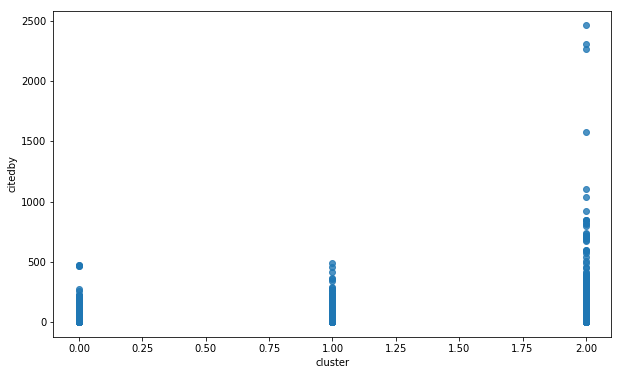

In [154]:
df['cluster'] = model.labels_

sns.regplot(df.cluster, df.citedby, fit_reg = False)

In [147]:
df.groupby(['school']).cluster.value_counts()

school   cluster
Cornell  2           210
         1            64
         0            17
Davis    2          1233
         1           204
         0            57
Florida  2          1337
         1           816
         0           359
Ohio     2           365
         0            39
         1            22
TAMU     2          1794
         0           916
         1            59
Name: cluster, dtype: int64

Based on the above, each school did not fall neatly into one cluster as I had hoped. This lack of splitting may explain why the knn regression to predict school based on titles did not work well.

Note: There is probably a better, built-in way to do what the following function does, but I didn't know how, so I wrote this function myself. I basically want the same information that value_counts() provides, but I want the values next to each other (in columns) instead of in separate rows. In addition to re-inventing the wheel, my function is also slow. 

In [149]:
def count_clusters(name):
    """Count the number of publications in each cluster for a given person"""
    c0 = 0
    c1 = 0
    c2 = 0
    for i in range(len(df[df.name == name])):
        if df[df.name == name]['cluster'].tolist()[i]==0:
            c0 += 1
        if df[df.name == name]['cluster'].tolist()[i]==1:
            c1 += 1
        if df[df.name == name]['cluster'].tolist()[i]==2:
            c2 += 1
    c.loc[c.name == name,"cluster0"]=c0
    c.loc[c.name == name,"cluster1"]=c1
    c.loc[c.name == name,"cluster2"]=c2
    return;

In [152]:
names = df.name.unique()
c = pd.DataFrame(names)
c.columns = ['name']

c['cluster0'] = 0
c['cluster1'] = 0
c['cluster2'] = 0

for i in names:
    count_clusters(i)

c

,name,cluster0,cluster1,cluster2
0,Berger,0,0,157
1,Eadie,0,0,121
2,Horback,0,0,14
3,Kebreab,18,133,280
4,Kueltz,0,0,110
5,Liu,21,0,20
6,Makagon,1,0,30
7,Medrano,14,14,275
8,Miller,121,0,113
9,Ross,0,3,117


From the above, we can see that some professors have a majority of their publications in a single cluster, but others are very evenly split between two clusters, and one is evenly split between all three clusters. Because of this, it seems that it would be hard to predict the author based on the text, which may explain why the knn regression model didn't work well. 